# Deep dive into Computational Psychology: Creating a lie detector test using a Convolutional Neural Network and Logistic Regression




Employing Convolutional Neural Networks (CNN) and Logistic Regression to detect concealed information, commonly referred to as "lying". The data is extracted from Wiese et al (2021), and looks at neuronal activity for a set of given patients. 

# Table of Contents

1. <ins>Data Pre-Processing</ins>
2. <ins>Logistic Regression Model</ins>
3. <ins>Convolutional Neural Network (CNN) Model</ins>
4. <ins>Comparative Analysis</ins>
5. <ins>Visualization</ins>


# 1. Data Pre-Processing



### Importing Libraries

In [1]:
import pandas as pd
import os
import glob
import numpy as np
from numpy import loadtxt
from openpyxl import load_workbook

### Loading Data

The data comprises of 19 patients and 3 excel files each: one for the neuronal activity when the patient is unfamiliar, one highlighting the neuronal activity when the patient is familiar, and one highlighting the neuronal activity when the patient is lying. We have a total of 57 excel files (3 * 19).

In [2]:
# Define paths to the directories containing the data files
path_unfamiliar = "/Users/gregorycrooks/Desktop/Dissertation Data/Unfamiliar"
path_lying = "/Users/gregorycrooks/Desktop/Dissertation Data/Lying"
path_true = "/Users/gregorycrooks/Desktop/Dissertation Data/True"

# Get sorted lists of all CSV files in each directory
csv_files_unfamiliar = np.sort(glob.glob(os.path.join(path_unfamiliar, "*.csv")))
csv_files_lying = np.sort(glob.glob(os.path.join(path_lying, "*.csv")))
csv_files_true = np.sort(glob.glob(os.path.join(path_true, "*.csv")))


### Downsampling Data

- In the experiment, each participant looks at 25 to 40 images (expressed as trials). In the datasets showing the neuronal activity, each trial is 614 rows. If a participant looks at 40 images, then the excel file has 24 560 rows. This represents a significant amount of computational space, since we have 57 files. 

- To reduce dimensionality, we calculate the mean for every ∼61.4 rows (or every 1/10 of a trial, or ∼0.12s) and created a new datapoint. This reduces dimensionality by 61.4.

In [4]:
# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings("ignore")

# Define a function to load and process EEG data files
def load_file(path, participant_ind, filter=["TP9", "TP10", "P9", "P10"]):
    # Read data from the file, skipping the first row
    data = pd.read_fwf(path, skiprows = 1)
    out = []

    dfs_out = []
    # Split data into trials of 614 rows each
    for ind, i in enumerate(range((data.shape[0]+614)//614)):
        out += [i+1]*614

        start_value = i*614
        end_value = start_value+610

        # Select the current trial segment
        df = data.iloc[start_value:end_value]
        # Assign trial index and participant ID
        df.iloc[:]["trial_ind"] = i+1
        df['participant_id'] = participant_ind
        dfs_out.append(df)
        
    # Concatenate all trial segments
    data = pd.concat(dfs_out)
    # Initialize a new dictionary to store downsampled data
    new_df = {column:[] for column in data.columns}

    # Downsample the data by averaging every 61 rows
    for i in range(data.shape[0]//61):
        if i*61+61>data.shape[0]:
            break

        temp_data = data.iloc[i*61:i*61+61, :].mean(axis=0)
        
        # Append the mean values to the new dictionary
        for item in temp_data.index:
            new_df[item].append(temp_data[item])
    
    # Return a DataFrame with downsampled data, retaining only specified channels
    return pd.DataFrame.from_dict(new_df)[filter]


### Data Transformation 

In [5]:
# Initialize a list to store the processed data for unfamiliar condition
unfamiliar_data = []
# Loop through each file path in the unfamiliar category
for ind, path in enumerate(csv_files_unfamiliar):
    # Print progress of loading unfamiliar data
    print(F'\rUnfamiliar: {ind}/{len(csv_files_unfamiliar)}', end='')
    # Load and process the file, then append to the list
    unfamiliar_data.append(load_file(path, ind+1))
print('')

# Initialize a list to store the processed data for lying condition
lying_data = []
# Loop through each file path in the lying category
for ind, path in enumerate(csv_files_lying):
    # Print progress of loading lying data
    print(F'\rLying: {ind}/{len(csv_files_lying)}', end='')
    # Load and process the file, then append to the list
    lying_data.append(load_file(path, ind+1))
print('')

# Initialize a list to store the processed data for true condition
true_data = []
# Loop through each file path in the true category
for ind, path in enumerate(csv_files_true):
    # Print progress of loading true data
    print(F'\rTrue: {ind}/{len(csv_files_true)}', end='')
    # Load and process the file, then append to the list
    true_data.append(load_file(path, ind+1))
print('')


Unfamiliar: 18/19
Lying: 18/19
True: 18/19


### Splitting Data into Training and Testing sets

Data is split by excel files rather than samples: 10 documents for the unfamiliar training set, 9 documents for the unfamiliar testing set, 10 documents for the lying training set, 9 documents for the lying testing set, 10 documents for the true training set, 9 documents for the true testing set. This specific split is done to ensure that all the images are taken into account in each respective split.

In [7]:
split_value = 10

unfamiliar_train, unfamiliar_test = unfamiliar_data[:split_value], unfamiliar_data[split_value:] 
lying_train, lying_test = lying_data[:split_value], lying_data[split_value:] 
true_train, true_test = true_data[:split_value], true_data[split_value:] 

# 2. Logistic Regression Model

### Preparing Data for Logistic Regression

In [8]:
from matplotlib import pyplot as plt
import numpy as np

# Function to process data
def process_data(unfamiliar_data, lying_data, true_data, label_unfamiliar=0, label_lying=1, label_true=2):
    # Stack and label unfamiliar data
    X_unf = np.vstack(unfamiliar_data)
    X_unf = np.hstack((X_unf, np.full((X_unf.shape[0], 1), label_unfamiliar)))

    # Stack and label lying data
    X_lying = np.vstack(lying_data)
    X_lying = np.hstack((X_lying, np.full((X_lying.shape[0], 1), label_lying)))

    # Stack and label true data
    X_true = np.vstack(true_data)
    X_true = np.hstack((X_true, np.full((X_true.shape[0], 1), label_true)))

    # Combine all data
    data = np.vstack((X_unf, X_lying, X_true))
    X = data[:, :-1]
    y = data[:, -1]
    return X, y

# Process training data
X_train, y_train = process_data(unfamiliar_train, lying_train, true_train)

# Process test data
X_test, y_test = process_data(unfamiliar_test, lying_test, true_test)


### Logistic Regression Model 1

We find that the Logistic Regression Model has pretty low accuracy when predicting labels. Although the model does correctly predict the "unfamiliar" label most of the times, we find an imbalance and over prediction on that label.


In [9]:
# Import necessary libraries for Logistic Regression, data visualization, and accuracy scoring
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import accuracy_score

# Initialize Logistic Regression model
LR = LogisticRegression()

# Fit the Logistic Regression model using the training data
LR_fit = LR.fit(X_train, y_train)

# Predict the labels for the test data
LR_pred = LR_fit.predict(X_test)

# Calculate and print the accuracy of the Logistic Regression model
print("Logistic Regression is %f percent accurate" % (accuracy_score(LR_pred, y_test)*100))

# The following section classifies each millisecond, then takes the average over each millisecond


Logistic Regression is 35.125881 percent accurate


### Confusion Matrix for Logistic Regression Model 1

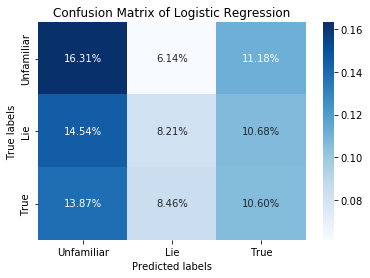

In [11]:
# Compute the confusion matrix
cf_matrix_lr = confusion_matrix(y_test, LR_pred)

# Plot the confusion matrix
ax = plt.subplot()
sns.heatmap(cf_matrix_lr / np.sum(cf_matrix_lr), annot=True, fmt='.2%', cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Logistic Regression')
ax.xaxis.set_ticklabels(['Unfamiliar', 'Lie', 'True'])
ax.yaxis.set_ticklabels(['Unfamiliar', 'Lie', 'True'])
plt.show()

### Logistic Regression Model 2

This other Logistic Regression Model  predicts each millisecond, but for each participant, it takes the mode for that participant of every millisecond so the most frequent poredicted value, and uses that value to classify that participant into lying, unfamiliar, true.

In [12]:
# Import the stats module from scipy for statistical functions
from scipy import stats

# Group the test data for all categories (unfamiliar, lying, true)
X_test_grouped = unfamiliar_test + lying_test + true_test

# Initialize an empty list to store predictions
preds = []

# Create labels corresponding to the test data categories
labels = [0] * len(unfamiliar_test) + [1] * len(lying_test) + [2] * len(true_test)

# Ensure the test data is grouped again for clarity
X_test_grouped = unfamiliar_test + lying_test + true_test

# Initialize the predictions list again for clarity
preds = []

# Assign labels corresponding to the test data categories again for clarity
labels = [0] * len(unfamiliar_test) + [1] * len(lying_test) + [2] * len(true_test)

# Loop through each item in the grouped test data and its corresponding label
for item, label in zip(X_test_grouped, labels):
    # Predict the label for each item using the trained Logistic Regression model
    # Use the mode of the predictions to classify each item
    preds.append(stats.mode(LR_fit.predict(item))[0][0])


In [13]:
from scipy import stats
X_test_grouped = unfamiliar_test+lying_test+true_test

preds = []
labels = [0]*len(unfamiliar_test)+[1]*len(lying_test)+[2]*len(true_test)
for item, label in zip(X_test_grouped, labels):
    preds.append(stats.mode(LR_fit.predict(item))[0][0])



In [14]:
for pred, label in zip(preds, labels):
    print(f"Prediction: {pred}, label: {label}")
    pass
accuracy = (np.array(preds)==np.array(labels)).mean()*100
print(f"accuracy: {accuracy}%")

Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 2.0, label: 0
Prediction: 2.0, label: 0
Prediction: 0.0, label: 1
Prediction: 2.0, label: 1
Prediction: 2.0, label: 1
Prediction: 0.0, label: 1
Prediction: 0.0, label: 1
Prediction: 0.0, label: 1
Prediction: 1.0, label: 1
Prediction: 2.0, label: 1
Prediction: 2.0, label: 1
Prediction: 0.0, label: 2
Prediction: 2.0, label: 2
Prediction: 2.0, label: 2
Prediction: 0.0, label: 2
Prediction: 0.0, label: 2
Prediction: 0.0, label: 2
Prediction: 1.0, label: 2
Prediction: 2.0, label: 2
Prediction: 2.0, label: 2
accuracy: 44.44444444444444%


### Confusion Matrix for Logistic Regression Model 2

The Logistic Regression model uses the most frequently predicted value for each participant over the 3 files, and uses that to predict the classification. This model assumes that a participant with more Lying trials will be more likely to have a Lying label in the logistic regression model. As a result, the number of trials for each given condition correlates with higher probability of this condition being predicted in a logistic regression model, which can arbitrary. For instance, the average number of trials for the Lying condition is the lowest out of the 3 with an average of 35.8 on average, which implies the Lying label will
rarely be predicted. This can be seen on the Confusion Matrix, since the Lying label has a very low prediction rate, accurate or inaccurate (7.40% of prediction rate). The overall model itself is accurate
with an overall 44.44% accuracy, surpassing the accuracy score of the first Logistic regression
model. 

[Text(0, 0.5, 'Unfamiliar'), Text(0, 1.5, 'Lie'), Text(0, 2.5, 'True')]

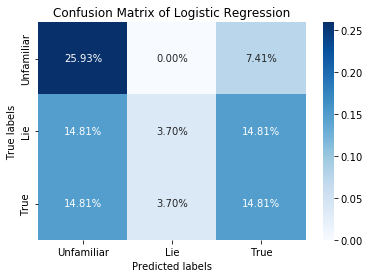

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
cf_matrix_lr = confusion_matrix(labels, preds)
sns.heatmap(cf_matrix_lr/np.sum(cf_matrix_lr), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Logistic Regression'); 
ax.xaxis.set_ticklabels(['Unfamiliar', 'Lie', 'True']); ax.yaxis.set_ticklabels(['Unfamiliar', 'Lie', 'True'])


# 3. Convolutional Neural network (CNN) Model

### Preparing Data for CNN

One of the limitations in our data is the imbalance, since participants did not necesarily look at the same number of images. Our solution to solve the imbalance issue is to look at the minimum
shape for all the stacked training data, which equals 250 rows after the data dimensionality is
reduced. Considering the multidimensional nature of CNNs, all the input layer  will take on an input shape of 250 x 4: 4 electrodes * 250 data samples. And the output layers will have a size of 3 considering our 3 features.

In [17]:
# Initialize a list to store the shapes of all arrays in the datasets
shapes = []

# Loop through each dataset and append the shape of each array to the shapes list
for item in [unfamiliar_train, lying_train, true_train, unfamiliar_test, lying_test, true_test]:
    for array in item:
        shapes.append(array.shape[0])
print()

# Find the minimum shape from the shapes list to ensure uniformity in data dimensions
min_shape = min(shapes)

# Stack the arrays for each category, ensuring they all have the same minimum shape
# This prepares the data for training the model
X_unf = np.stack([item.values[:min_shape, :] for item in unfamiliar_train])  # Label 0
X_lying = np.stack([item.values[:min_shape, :] for item in lying_train])     # Label 1
X_true = np.stack([item.values[:min_shape, :] for item in true_train])       # Label 2

# Combine the data into a single array for training
data = np.vstack((X_unf, X_lying, X_true))
X_train = data

# Create the corresponding labels for the training data
y_train = np.array([0]*X_unf.shape[0] + [1]*X_lying.shape[0] + [2]*X_true.shape[0])

# Repeat the same process for the test datasets
X_unf = np.stack([item.values[:min_shape, :] for item in unfamiliar_test])  # Label 0
X_lying = np.stack([item.values[:min_shape, :] for item in lying_test])     # Label 1
X_true = np.stack([item.values[:min_shape, :] for item in true_test])       # Label 2

# Combine the data into a single array for testing
data = np.vstack((X_unf, X_lying, X_true))
X_test = data

# Create the corresponding labels for the test data
y_test = np.array([0]*X_unf.shape[0] + [1]*X_lying.shape[0] + [2]*X_true.shape[0])

# Print the shapes of the training and test datasets to verify the dimensions
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}")



X_train.shape: (30, 250, 4), X_test.shape: (27, 250, 4)
y_train.shape: (30,), y_test.shape: (27,)


### Standardizing Data

In [18]:
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()
X_train_NN = SS.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_NN  = SS.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train_NN = y_train
y_test_NN = y_test


### CNN Model Arquitecture 1

The results vary across the training iterations and as we tested out different networks. One noticeable issue arising over 100 epochs is our model overfitting (Training set performing much better than the testing set).
One solution to overfitting was using keras.layers.Dropout which arbitrarily deactivates
certain nodes82. Our final dropout rate for this architecture was set as 0.5, thus, 50% of the
nodes were arbitrarily deactivated over each training iteration. As a result, the architecture seemed to generally perform much better.


In [19]:
# Set the dimensions of the input data
n_0 = min_shape  # Number of time points per trial
n_1 = 4          # Number of EEG channels

# Import necessary libraries from Keras for building the neural network
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense

# Initialize the Sequential model
model = Sequential()

# Add the first convolutional layer with 32 filters, kernel size of 3, ReLU activation, and input shape
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(n_0, n_1)))

# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add the second convolutional layer with the same specifications
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))

# Add another Dropout layer
model.add(Dropout(0.5))

# Add the third convolutional layer with the same specifications
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))

# Add another Dropout layer
model.add(Dropout(0.5))

# Add a MaxPooling layer to downsample the input
model.add(MaxPooling1D(2))

# Flatten the input for the Dense layers
model.add(Flatten())

# Add a Dense layer with 100 units and ReLU activation
model.add(Dense(100, "relu"))

# Add another Dropout layer
model.add(Dropout(0.5))

# Add the output Dense layer with 3 units and softmax activation for multi-class classification
model.add(Dense(3, "softmax"))

# Import TensorFlow for optimization
import tensorflow as tf

# Define the optimizer with a learning rate of 0.0001
opt = tf.keras.optimizers.Adam(lr=0.0001)

# Compile the model with sparse categorical cross-entropy loss and accuracy metric
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit the model on the training data for 100 epochs with a batch size of 18 and validate on the test data
model.fit(X_train_NN, y_train_NN, epochs=100, batch_size=18, validation_data=(X_test_NN, y_test_NN))


2024-08-07 18:38:45.089087: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
2/2 [==============================] - 2s 433ms/step - loss: 1.6228 - accuracy: 0.2333 - val_loss: 1.1008 - val_accuracy: 0.4074
Epoch 2/100
2/2 [==============================] - 0s 203ms/step - loss: 1.6353 - accuracy: 0.2333 - val_loss: 1.0943 - val_accuracy: 0.3704
Epoch 3/100
2/2 [==============================] - 0s 127ms/step - loss: 1.2323 - accuracy: 0.3667 - val_loss: 1.0933 - val_accuracy: 0.4444
Epoch 4/100
2/2 [==============================] - 0s 129ms/step - loss: 1.4692 - accuracy: 0.3000 - val_loss: 1.0933 - val_accuracy: 0.3704
Epoch 5/100
2/2 [==============================] - 0s 116ms/step - loss: 1.2849 - accuracy: 0.3000 - val_loss: 1.0915 - val_accuracy: 0.4074
Epoch 6/100
2/2 [==============================] - 0s 121ms/step - loss: 1.3569 - accuracy: 0.4333 - val_loss: 1.0893 - val_accuracy: 0.4074
Epoch 7/100
2/2 [==============================] - 0s 93ms/step - loss: 0.8850 - accuracy: 0.6000 - val_loss: 1.0872 - val_accuracy: 0.3333
Epoch 8/100
2/

Looking at the output with the Confusion Matrix from this CNN model, we find better results than the Logistic Regression, which combines an overall accuracy of ∼ 60% as opposed to 35% with thetraditional Logistic Regression model. This model is especially effective in predicting the correct labels for the Unfamiliar and True labels, with both having an accuracy rate of
22.22% (out of 33.33%). The accuracy rate of having true labels for the Lying classification is
much better in the network than in either Logistic Regression model with a 14.81% accuracy.
However, one similarity is that the model has a lower accuracy than the Unfamiliar or True
labels. To further inspect how the network can be improved, we attempted to create other
network architectures and see how those improve our model accuracy

The accuracy score for this CNN is 40.11904761904762 %


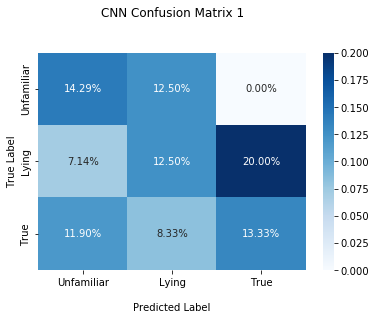

In [20]:
# Import ConfusionMatrixDisplay for visualizing the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Predict the labels for the test data using the trained CNN model
y_predictions = model.predict(x = X_test_NN)

# Convert the predicted probabilities to class labels
rounded_predictions = np.argmax(y_predictions, axis = 1)

# Compute the confusion matrix, normalized by the number of predictions
cm = confusion_matrix(y_test, rounded_predictions, normalize='pred')

# Create a heatmap to visualize the confusion matrix
ax = sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
ax.set_title('CNN Confusion Matrix 1\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Unfamiliar', 'Lying', 'True'])
ax.yaxis.set_ticklabels(['Unfamiliar', 'Lying', 'True'])

# Calculate the overall accuracy score by summing the diagonal elements of the confusion matrix
perc_acc = np.array(cm / np.sum(cm)).flatten()
acc_score = perc_acc[0] + perc_acc[4] + perc_acc[8]
print('The accuracy score for this CNN is', acc_score * 100, '%')


### CNN Architecture 2:

Since the dropout rate was a significant factor in reducing overfitting and improving our
model accuracy, I increased the dropout rate to 0.7 (i.e., having 70% of the nodes
arbitrarily deactivated over the model’s training iterations). 

In [21]:
# Set the dimensions of the input data
n_0 = min_shape  # Number of time points per trial
n_1 = 4          # Number of EEG channels

# Import necessary libraries from Keras for building the neural network
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense

# Initialize the Sequential model
model = Sequential()

# Add the first convolutional layer with 32 filters, kernel size of 3, ReLU activation, and input shape
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(n_0, n_1)))

# Add a Dropout layer with 70% dropout rate to prevent overfitting
model.add(Dropout(0.7))

# Add the second convolutional layer with the same specifications
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))

# Add another Dropout layer with 70% dropout rate
model.add(Dropout(0.7))

# Add the third convolutional layer with the same specifications
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))

# Add another Dropout layer with 70% dropout rate
model.add(Dropout(0.7))

# Add a MaxPooling layer to downsample the input
model.add(MaxPooling1D(2))

# Flatten the input for the Dense layers
model.add(Flatten())

# Add a Dense layer with 100 units and ReLU activation
model.add(Dense(100, "relu"))

# Add another Dropout layer with 50% dropout rate
model.add(Dropout(0.5))

# Add the output Dense layer with 3 units and softmax activation for multi-class classification
model.add(Dense(3, "softmax"))

# Import TensorFlow for optimization
import tensorflow as tf

# Define the optimizer with a learning rate of 0.0001
opt = tf.keras.optimizers.Adam(lr=0.0001)

# Compile the model with sparse categorical cross-entropy loss and accuracy metric
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit the model on the training data for 150 epochs with a batch size of 18 and validate on the test data
model.fit(X_train_NN, y_train_NN, epochs=150, batch_size=18, validation_data=(X_test_NN, y_test_NN))


Epoch 1/150
2/2 [==============================] - 2s 648ms/step - loss: 2.3318 - accuracy: 0.4000 - val_loss: 1.1093 - val_accuracy: 0.3333
Epoch 2/150
2/2 [==============================] - 0s 109ms/step - loss: 1.4046 - accuracy: 0.4667 - val_loss: 1.1040 - val_accuracy: 0.3704
Epoch 3/150
2/2 [==============================] - 0s 107ms/step - loss: 2.6440 - accuracy: 0.2000 - val_loss: 1.1026 - val_accuracy: 0.2963
Epoch 4/150
2/2 [==============================] - 0s 111ms/step - loss: 2.1745 - accuracy: 0.3333 - val_loss: 1.1038 - val_accuracy: 0.3333
Epoch 5/150
2/2 [==============================] - 0s 149ms/step - loss: 2.1234 - accuracy: 0.2667 - val_loss: 1.1054 - val_accuracy: 0.2963
Epoch 6/150
2/2 [==============================] - 0s 108ms/step - loss: 1.4335 - accuracy: 0.4333 - val_loss: 1.1063 - val_accuracy: 0.3333
Epoch 7/150
2/2 [==============================] - 0s 96ms/step - loss: 2.1970 - accuracy: 0.4333 - val_loss: 1.1049 - val_accuracy: 0.2963
Epoch 8/150
2/

In [ ]:
# Import ConfusionMatrixDisplay for visualizing the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Predict the labels for the test data using the trained CNN model
y_predictions = model.predict(x = X_test_NN)

# Convert the predicted probabilities to class labels
rounded_predictions = np.argmax(y_predictions, axis = 1)

# Compute the confusion matrix, normalized by the number of predictions
cm = confusion_matrix(y_test, rounded_predictions, normalize='pred')

# Create a heatmap to visualize the confusion matrix
ax = sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
ax.set_title('CNN Confusion Matrix 2\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Unfamiliar', 'Lying', 'True'])
ax.yaxis.set_ticklabels(['Unfamiliar', 'Lying', 'True'])

# Calculate the overall accuracy score by summing the diagonal elements of the confusion matrix
perc_acc = np.array(cm / np.sum(cm)).flatten()
acc_score = perc_acc[0] + perc_acc[4] + perc_acc[8]
print('The accuracy score for this CNN is', acc_score * 100, '%')

# Visualize the architecture of the CNN model and save it to a file
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [40]:
# Set the dimensions of the input data
n_0 = min_shape  # Number of time points per trial
n_1 = 4          # Number of EEG channels

# Import necessary libraries from Keras for building the neural network
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense

# Initialize the Sequential model
model = Sequential()

# Add the first convolutional layer with 32 filters, kernel size of 3, ReLU activation, and input shape
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(n_0, n_1)))

# Add a Dropout layer with 50% dropout rate to prevent overfitting
model.add(keras.layers.Dropout(0.5))

# Add the second convolutional layer with the same specifications
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))

# Add another Dropout layer with 50% dropout rate
model.add(keras.layers.Dropout(0.5))

# Add the third convolutional layer with the same specifications
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))

# Add another Dropout layer with 50% dropout rate
model.add(keras.layers.Dropout(0.5))

# Add a MaxPooling layer to downsample the input with pool size of 3
model.add(keras.layers.MaxPooling1D(3))

# Flatten the input for the Dense layers
model.add(Flatten())

# Add a Dense layer with 100 units and ReLU activation
model.add(Dense(100, "relu"))

# Add another Dense layer with 100 units and ReLU activation
model.add(Dense(100, "relu"))

# Add another Dropout layer with 60% dropout rate
model.add(keras.layers.Dropout(0.6))

# Add the output Dense layer with 3 units and softmax activation for multi-class classification
model.add(Dense(3, "softmax"))

# Import TensorFlow for optimization
import tensorflow as tf

# Define the optimizer with a learning rate of 0.0001
opt = tf.keras.optimizers.Adam(lr=0.0001)

# Compile the model with sparse categorical cross-entropy loss and accuracy metric
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit the model on the training data for 150 epochs with a batch size of 20 and validate on the test data
model.fit(X_train_NN, y_train_NN, epochs=150, batch_size=20, validation_data=(X_test_NN, y_test_NN))


Epoch 1/150
2/2 [==============================] - 1s 314ms/step - loss: 1.4162 - accuracy: 0.4667 - val_loss: 1.1084 - val_accuracy: 0.3704
Epoch 2/150
2/2 [==============================] - 0s 102ms/step - loss: 1.3976 - accuracy: 0.2667 - val_loss: 1.1036 - val_accuracy: 0.3333
Epoch 3/150
2/2 [==============================] - 0s 86ms/step - loss: 1.5476 - accuracy: 0.2333 - val_loss: 1.1005 - val_accuracy: 0.2963
Epoch 4/150
2/2 [==============================] - 0s 69ms/step - loss: 1.3732 - accuracy: 0.2333 - val_loss: 1.0987 - val_accuracy: 0.2963
Epoch 5/150
2/2 [==============================] - 0s 71ms/step - loss: 1.3186 - accuracy: 0.2667 - val_loss: 1.0968 - val_accuracy: 0.3704
Epoch 6/150
2/2 [==============================] - 0s 67ms/step - loss: 1.2001 - accuracy: 0.3000 - val_loss: 1.0950 - val_accuracy: 0.3333
Epoch 7/150
2/2 [==============================] - 0s 67ms/step - loss: 1.3673 - accuracy: 0.3000 - val_loss: 1.0936 - val_accuracy: 0.3704
Epoch 8/150
2/2 [=

The accuracy score for this CNN is 28.253968253968253 %


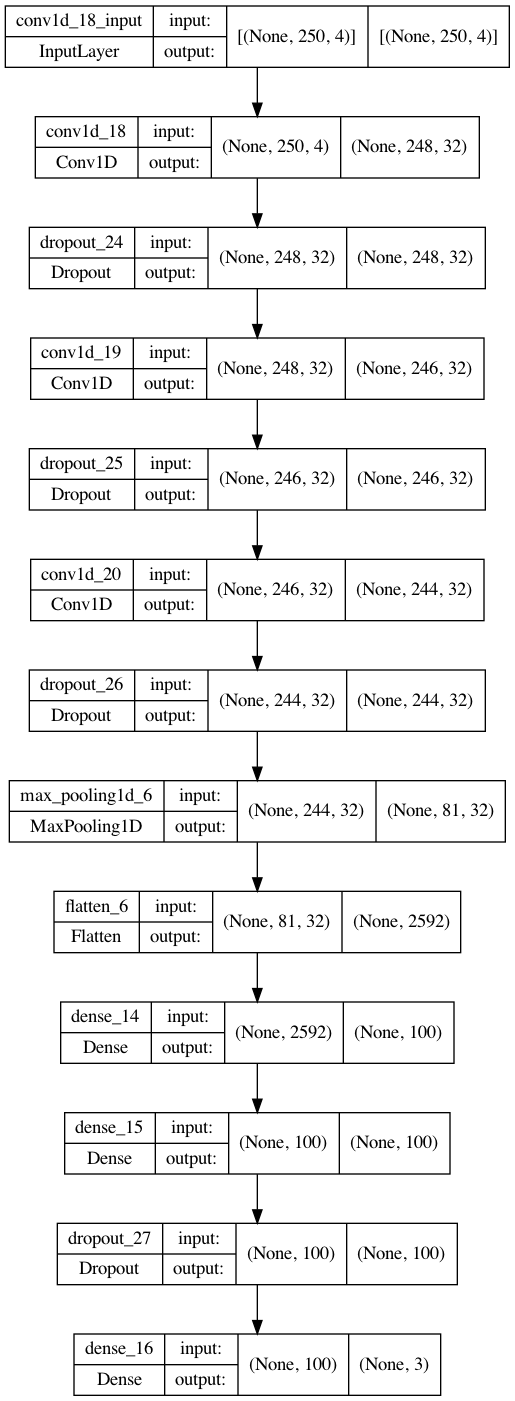

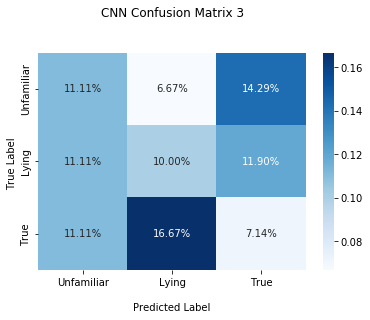

In [41]:
# Import ConfusionMatrixDisplay for visualizing the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Predict the labels for the test data using the trained CNN model
y_predictions = model.predict(x = X_test_NN)

# Convert the predicted probabilities to class labels
rounded_predictions = np.argmax(y_predictions, axis = 1)

# Compute the confusion matrix, normalized by the number of predictions
cm = confusion_matrix(y_test, rounded_predictions, normalize='pred')

# Create a heatmap to visualize the confusion matrix
ax = sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
ax.set_title('CNN Confusion Matrix 3\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Unfamiliar', 'Lying', 'True'])
ax.yaxis.set_ticklabels(['Unfamiliar', 'Lying', 'True'])

# Calculate the overall accuracy score by summing the diagonal elements of the confusion matrix
perc_acc = np.array(cm / np.sum(cm)).flatten()
acc_score = perc_acc[0] + perc_acc[4] + perc_acc[8]
print('The accuracy score for this CNN is', acc_score * 100, '%')

# Visualize the architecture of the CNN model and save it to a file
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Set the dimensions of the input data
n_0 = min_shape  # Number of time points per trial
n_1 = 4          # Number of EEG channels

# Import necessary libraries from Keras for building the neural network
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense

# Initialize the Sequential model
model = Sequential()

# Add the first convolutional layer with 32 filters, kernel size of 3, ReLU activation, and input shape
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(n_0, n_1)))

# Add a Dropout layer with 50% dropout rate to prevent overfitting
model.add(keras.layers.Dropout(0.5))

# Add the second convolutional layer with the same specifications
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))

# Add another Dropout layer with 50% dropout rate
model.add(keras.layers.Dropout(0.5))

# Add the third convolutional layer with the same specifications
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))

# Add another Dropout layer with 50% dropout rate
model.add(keras.layers.Dropout(0.5))

# Add a MaxPooling layer to downsample the input with pool size of 3
model.add(keras.layers.MaxPooling1D(3))

# Flatten the input for the Dense layers
model.add(Flatten())

# Add a Dense layer with 100 units and ReLU activation
model.add(Dense(100, "relu"))

# Add another Dense layer with 100 units and ReLU activation
model.add(Dense(100, "relu"))

# Add another Dropout layer with 50% dropout rate
model.add(keras.layers.Dropout(0.5))

# Add the output Dense layer with 3 units and softmax activation for multi-class classification
model.add(Dense(3, "softmax"))

# Import TensorFlow for optimization
import tensorflow as tf

# Define the optimizer with a learning rate of 0.0001
opt = tf.keras.optimizers.Adam(lr=0.0001)

# Compile the model with sparse categorical cross-entropy loss and accuracy metric
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit the model on the training data for 150 epochs with a batch size of 18 and validate on the test data
model.fit(X_train_NN, y_train_NN, epochs=150, batch_size=18, validation_data=(X_test_NN, y_test_NN))


The accuracy score for this CNN is 37.797619047619044 %


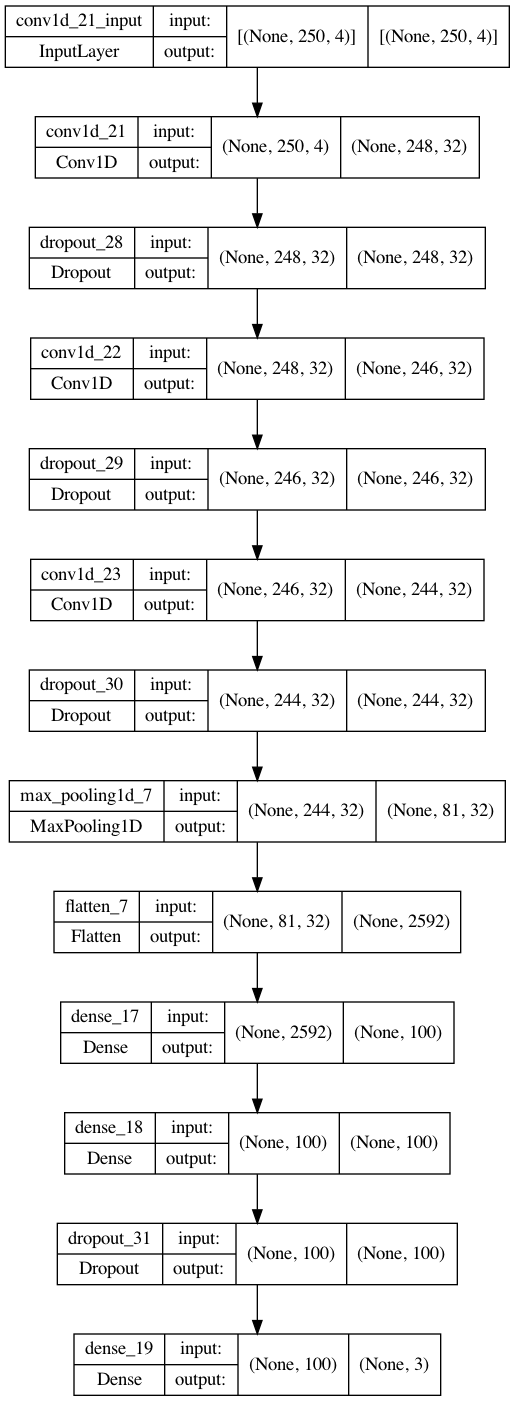

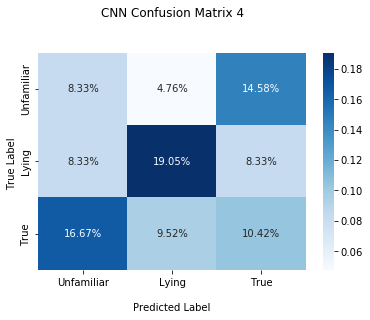

In [43]:
# Import ConfusionMatrixDisplay for visualizing the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Predict the labels for the test data using the trained CNN model
y_predictions = model.predict(x = X_test_NN)

# Convert the predicted probabilities to class labels
rounded_predictions = np.argmax(y_predictions, axis = 1)

# Compute the confusion matrix, normalized by the number of predictions
cm = confusion_matrix(y_test, rounded_predictions, normalize='pred')

# Create a heatmap to visualize the confusion matrix
ax = sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
ax.set_title('CNN Confusion Matrix 4\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Unfamiliar', 'Lying', 'True'])
ax.yaxis.set_ticklabels(['Unfamiliar', 'Lying', 'True'])

# Calculate the overall accuracy score by summing the diagonal elements of the confusion matrix
perc_acc = np.array(cm / np.sum(cm)).flatten()
acc_score = perc_acc[0] + perc_acc[4] + perc_acc[8]
print('The accuracy score for this CNN is', acc_score * 100, '%')

# Visualize the architecture of the CNN model and save it to a file
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
